In [ ]:
#@title imports

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import time
import copy
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x)  # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)
    my_dataset = data.TensorDataset(tensor_x, tensor_y)  # create your datset
    my_dataloader = data.DataLoader(my_dataset)  # create your dataloader
    return my_dataloader


def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
#@title dataloading
transform = transforms.ToTensor()
batch_size=100

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10('cifar-10', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('cifar-10', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valset, testset = torch.utils.data.random_split(testset, [1000, 9000])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)



Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Files already downloaded and verified


In [ ]:
#@title resnet_structure
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
! ls /gdrive/MyDrive

 Classroom				 Lab1_Linear_and_Ensembles.ipynb
 Colab_Lab1_SVM.ipynb			'Lab2 (1).ipynb'
'Colab Notebooks'			 Lab2.ipynb
 heatmap_big_temp.jpg			 Lab3.rar
 heatmap_small_temp.jpg			 model_2
 heatmap_val_big_temp.jpg		 train_loss.csv
 heatmap_val_small_temp.jpg		 val_loss.csv
 HW1_kNN_and_Logistic_regression.ipynb


In [ ]:
def weigheted_most_common(predictions, weights):
    new_predictions = {}
    for i in range(len(predictions)):
        if predictions[i] in new_predictions:
            new_predictions[predictions[i]] = new_predictions[predictions[i]] + weights[i]
        else:
            new_predictions[predictions[i]] = weights[i]
    top = list(sorted(new_predictions.items(), key=lambda item: item[1], reverse=True))
    return top[0][0]

    
from collections import Counter
import numpy as np
def ensemble_predictions(members, loader, weights):
    accs = []
    for (X_batch, y_batch) in loader:
        yhats = []
        for model in members:
            y_batch = y_batch.cuda()
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            yhats.append(y_pred.cpu().numpy())
        yhats = np.array(yhats)
        maxs = []
        for i in range(yhats.shape[1]):
            cur_max = weigheted_most_common(yhats[:, i], weights)
            maxs.append(cur_max)
        # sum across ensemble members
        maxs = np.array(maxs)
        # argmax across classes
        accs.append(np.mean((y_batch.cpu().numpy() == maxs)))
    accs = np.array(accs)
    return accs, np.mean(accs)

In [ ]:
models_list = []
for i in range(25):
    name = '/gdrive/MyDrive/model_2/model_' + str(i) + '.pt'
    model = ResNet(BasicBlock, [2,2,2,2]).cuda()
    model.load_state_dict(torch.load(name))
    models_list.append(model)

In [ ]:
current_models = models_list[-24:-8]
weights = [1.] * 24
accs, mean_accs = ensemble_predictions(current_models, testloader, weights)
print('Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

Ensemble accuracy =  90.10000000000001 %


In [ ]:
from numpy import genfromtxt
number_of_models = [2, 5, 8, 10, 15, 22]
temperatures = [0.1, 0.3, 0.5, 1.0, 1.5, 2.5, 5.0]
train_lik_loss = genfromtxt('/gdrive/MyDrive/train_loss.csv', delimiter=',')[-25:]
print(len(train_lik_loss))
#train loss

results = np.zeros((len(number_of_models), len(temperatures)))
for i in range(len(number_of_models)):
    num = number_of_models[i]
    current_models = models_list[-num:]
    for t in range(len(temperatures)):
            temp_constant = temperatures[t]
            loss_list = np.array(train_lik_loss[-len(current_models):])
            for j in range(loss_list.shape[0]):
                loss_list[j] = np.exp(np.exp(-loss_list[j]) / temp_constant)
            weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
            accs, mean_accs = ensemble_predictions(current_models, testloader, weights)
            results[i, t] = mean_accs
            print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25


NameError: ignored

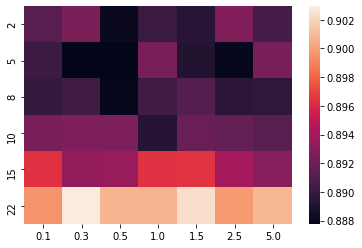

In [ ]:
from seaborn import heatmap
heatmap(results, xticklabels=temperatures, yticklabels=number_of_models)
import matplotlib.pyplot as plt
plt.savefig('/gdrive/MyDrive/heatmap_big_temp.jpg')

In [ ]:
from numpy import genfromtxt
number_of_models = [10, 15, 17, 20, 22, 24]
temperatures = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3]
train_lik_loss = genfromtxt('/gdrive/MyDrive/train_loss.csv', delimiter=',')[-25:]
print(len(train_lik_loss))
#train loss

results = np.zeros((len(number_of_models), len(temperatures)))
for i in range(len(number_of_models)):
    num = number_of_models[i]
    current_models = models_list[-num:]
    for t in range(len(temperatures)):
            temp_constant = temperatures[t]
            loss_list = np.array(train_lik_loss[-len(current_models):])
            for j in range(loss_list.shape[0]):
                loss_list[j] = np.exp(np.exp(-loss_list[j]) / temp_constant)
            weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
            accs, mean_accs = ensemble_predictions(current_models, testloader, weights)
            results[i, t] = mean_accs
            print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
0 Ensemble accuracy =  89.0 %
1 Ensemble accuracy =  88.9 %
2 Ensemble accuracy =  89.2 %
3 Ensemble accuracy =  89.1 %
4 Ensemble accuracy =  89.1 %
5 Ensemble accuracy =  88.9 %
6 Ensemble accuracy =  89.0 %
0 Ensemble accuracy =  89.60000000000001 %
1 Ensemble accuracy =  89.5 %
2 Ensemble accuracy =  89.60000000000001 %
3 Ensemble accuracy =  89.7 %
4 Ensemble accuracy =  89.5 %
5 Ensemble accuracy =  89.60000000000001 %
6 Ensemble accuracy =  89.4 %
0 Ensemble accuracy =  89.7 %
1 Ensemble accuracy =  89.3 %
2 Ensemble accuracy =  89.9 %
3 Ensemble accuracy =  89.9 %
4 Ensemble accuracy =  89.8 %
5 Ensemble accuracy =  89.8 %
6 Ensemble accuracy =  89.8 %
0 Ensemble accuracy =  90.10000000000001 %
1 Ensemble accuracy =  89.9 %
2 Ensemble accuracy =  90.0 %
3 Ensemble accuracy =  90.0 %
4 Ensemble accuracy =  89.9 %
5 Ensemble accuracy =  89.8 %
6 Ensemble accuracy =  89.8 %
0 Ensemble accuracy =  89.9 %
1 Ensemble accuracy =  90.10000000000001 %
2 Ensemble accuracy =  90.3 %
3 

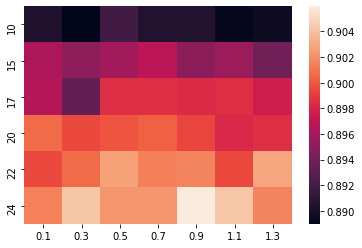

In [ ]:
from seaborn import heatmap
heatmap(results, xticklabels=temperatures, yticklabels=number_of_models)
import matplotlib.pyplot as plt
plt.savefig('/gdrive/MyDrive/heatmap_small_temp.jpg')

In [ ]:
from numpy import genfromtxt
number_of_models = [2, 5, 8, 10, 15, 22]
temperatures = [0.1, 0.3, 0.5, 1.0, 1.5, 2.5, 5.0]
train_lik_loss = genfromtxt('/gdrive/MyDrive/val_loss.csv', delimiter=',')[-25:]
print(len(train_lik_loss))
#train loss

results = np.zeros((len(number_of_models), len(temperatures)))
for i in range(len(number_of_models)):
    num = number_of_models[i]
    current_models = models_list[-num:]
    for t in range(len(temperatures)):
            temp_constant = temperatures[t]
            loss_list = np.array(train_lik_loss[-len(current_models):])
            for j in range(loss_list.shape[0]):
                loss_list[j] = np.exp(np.exp(-loss_list[j]) / temp_constant)
            weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
            accs, mean_accs = ensemble_predictions(current_models, testloader, weights)
            results[i, t] = mean_accs
            print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
0 Ensemble accuracy =  89.0 %
1 Ensemble accuracy =  88.6 %
2 Ensemble accuracy =  89.0 %
3 Ensemble accuracy =  88.9 %
4 Ensemble accuracy =  89.4 %
5 Ensemble accuracy =  88.9 %
6 Ensemble accuracy =  89.1 %
0 Ensemble accuracy =  89.1 %
1 Ensemble accuracy =  89.2 %
2 Ensemble accuracy =  88.8 %
3 Ensemble accuracy =  88.9 %
4 Ensemble accuracy =  89.0 %
5 Ensemble accuracy =  88.9 %
6 Ensemble accuracy =  88.9 %
0 Ensemble accuracy =  88.9 %
1 Ensemble accuracy =  89.0 %
2 Ensemble accuracy =  89.0 %
3 Ensemble accuracy =  89.1 %
4 Ensemble accuracy =  89.0 %
5 Ensemble accuracy =  89.0 %
6 Ensemble accuracy =  89.0 %
0 Ensemble accuracy =  88.9 %
1 Ensemble accuracy =  88.9 %
2 Ensemble accuracy =  89.3 %
3 Ensemble accuracy =  89.0 %
4 Ensemble accuracy =  88.9 %
5 Ensemble accuracy =  89.3 %
6 Ensemble accuracy =  88.9 %
0 Ensemble accuracy =  89.5 %
1 Ensemble accuracy =  89.4 %
2 Ensemble accuracy =  89.60000000000001 %
3 Ensemble accuracy =  89.5 %
4 Ensemble accuracy =  8

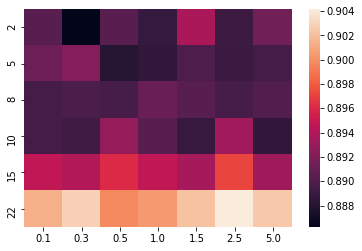

In [ ]:
from seaborn import heatmap
heatmap(results, xticklabels=temperatures, yticklabels=number_of_models)
import matplotlib.pyplot as plt
plt.savefig('/gdrive/MyDrive/heatmap_val_big_temp.jpg')

In [ ]:
from numpy import genfromtxt
number_of_models = [10, 15, 17, 20, 22, 24]
temperatures = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3]
train_lik_loss = genfromtxt('/gdrive/MyDrive/val_loss.csv', delimiter=',')[-25:]
print(len(train_lik_loss))
#train loss

results = np.zeros((len(number_of_models), len(temperatures)))
for i in range(len(number_of_models)):
    num = number_of_models[i]
    current_models = models_list[-num:]
    for t in range(len(temperatures)):
            temp_constant = temperatures[t]
            loss_list = np.array(train_lik_loss[-len(current_models):])
            for j in range(loss_list.shape[0]):
                loss_list[j] = np.exp(np.exp(-loss_list[j]) / temp_constant)
            weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
            accs, mean_accs = ensemble_predictions(current_models, testloader, weights)
            results[i, t] = mean_accs
            print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
0 Ensemble accuracy =  89.0 %
1 Ensemble accuracy =  89.3 %
2 Ensemble accuracy =  89.0 %
3 Ensemble accuracy =  88.9 %
4 Ensemble accuracy =  88.8 %
5 Ensemble accuracy =  89.0 %
6 Ensemble accuracy =  89.1 %
0 Ensemble accuracy =  89.8 %
1 Ensemble accuracy =  89.60000000000001 %
2 Ensemble accuracy =  89.7 %
3 Ensemble accuracy =  89.4 %
4 Ensemble accuracy =  89.7 %
5 Ensemble accuracy =  89.4 %
6 Ensemble accuracy =  89.4 %
0 Ensemble accuracy =  89.7 %
1 Ensemble accuracy =  89.8 %
2 Ensemble accuracy =  89.4 %
3 Ensemble accuracy =  89.7 %
4 Ensemble accuracy =  89.7 %
5 Ensemble accuracy =  89.8 %
6 Ensemble accuracy =  89.60000000000001 %
0 Ensemble accuracy =  90.4 %
1 Ensemble accuracy =  90.0 %
2 Ensemble accuracy =  90.2 %
3 Ensemble accuracy =  90.3 %
4 Ensemble accuracy =  90.10000000000001 %
5 Ensemble accuracy =  90.10000000000001 %
6 Ensemble accuracy =  90.2 %
0 Ensemble accuracy =  90.3 %
1 Ensemble accuracy =  90.5 %
2 Ensemble accuracy =  90.0 %
3 Ensemble accu

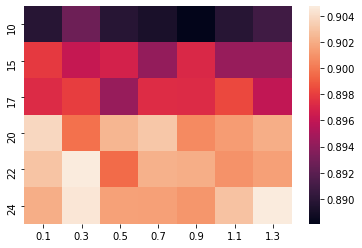

In [ ]:
from seaborn import heatmap
heatmap(results, xticklabels=temperatures, yticklabels=number_of_models)
import matplotlib.pyplot as plt
plt.savefig('/gdrive/MyDrive/heatmap_val_small_temp.jpg')

In [ ]:
from numpy import genfromtxt
number_of_models = [10, 15, 17, 20, 22, 24]
temperatures = [0.1, 0.3, 0.5, 1.0, 1.5, 2.5, 5.0]
train_lik_loss = genfromtxt('/gdrive/MyDrive/train_loss.csv', delimiter=',')[-25:]
print(len(train_lik_loss))
#train loss

results = np.zeros((len(number_of_models), len(temperatures)))
for i in range(len(number_of_models)):
    num = number_of_models[i]
    current_models = models_list[-num:]
    for t in range(len(temperatures)):
            temp_constant = temperatures[t]
            loss_list = np.array(train_lik_loss[-len(current_models):])
            for j in range(loss_list.shape[0]):
                loss_list[j] = np.exp(np.exp(-loss_list[j]) / temp_constant)
            weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
            accs, mean_accs = ensemble_predictions(current_models, valloader, weights)
            results[i, t] = mean_accs
            print(t, 'Ensemble accuracy = ', mean_accs)

25
0 Ensemble accuracy =  0.876
1 Ensemble accuracy =  0.882
2 Ensemble accuracy =  0.881
3 Ensemble accuracy =  0.8710000000000001
4 Ensemble accuracy =  0.8790000000000001
5 Ensemble accuracy =  0.883
6 Ensemble accuracy =  0.877
0 Ensemble accuracy =  0.882
1 Ensemble accuracy =  0.8880000000000001
2 Ensemble accuracy =  0.8779999999999999
3 Ensemble accuracy =  0.8869999999999999
4 Ensemble accuracy =  0.8880000000000001
5 Ensemble accuracy =  0.8880000000000001
6 Ensemble accuracy =  0.883
0 Ensemble accuracy =  0.8879999999999999
1 Ensemble accuracy =  0.8879999999999999
2 Ensemble accuracy =  0.8920000000000001
3 Ensemble accuracy =  0.8959999999999999
4 Ensemble accuracy =  0.8889999999999999
5 Ensemble accuracy =  0.8869999999999999
6 Ensemble accuracy =  0.884
0 Ensemble accuracy =  0.893
1 Ensemble accuracy =  0.8869999999999999
2 Ensemble accuracy =  0.891
3 Ensemble accuracy =  0.891
4 Ensemble accuracy =  0.891
5 Ensemble accuracy =  0.8880000000000001
6 Ensemble accuracy

In [ ]:
temp_constant = 0.1
current_models = models_list[-24:]
loss_list = np.array(train_lik_loss[-len(current_models):])
for j in range(loss_list.shape[0]):
    loss_list[j] = np.exp(np.exp(-loss_list[j]) / temp_constant)
weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
accs, mean_accs = ensemble_predictions(current_models, testloader, weights)
results[i, t] = mean_accs
print(t, 'Ensemble accuracy = ', mean_accs)

6 Ensemble accuracy =  0.9031111111111111


In [ ]:
from numpy import genfromtxt
number_of_models = [10, 15, 17, 20, 22, 24]
temperatures = [0.1, 0.3, 0.5, 1.0, 1.5, 2.5, 5.0]
train_lik_loss = genfromtxt('/gdrive/MyDrive/val_loss.csv', delimiter=',')[-25:]
print(len(train_lik_loss))
#train loss

results = np.zeros((len(number_of_models), len(temperatures)))
for i in range(len(number_of_models)):
    num = number_of_models[i]
    current_models = models_list[-num:]
    for t in range(len(temperatures)):
            temp_constant = temperatures[t]
            loss_list = np.array(train_lik_loss[-len(current_models):])
            for j in range(loss_list.shape[0]):
                loss_list[j] = np.exp(np.exp(-loss_list[j]) / temp_constant)
            weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
            accs, mean_accs = ensemble_predictions(current_models, valloader, weights)
            results[i, t] = mean_accs
            print(t, 'Ensemble accuracy = ', mean_accs)

25
0 Ensemble accuracy =  0.883
1 Ensemble accuracy =  0.8800000000000001
2 Ensemble accuracy =  0.877
3 Ensemble accuracy =  0.8879999999999999
4 Ensemble accuracy =  0.881
5 Ensemble accuracy =  0.889
6 Ensemble accuracy =  0.8790000000000001
0 Ensemble accuracy =  0.885
1 Ensemble accuracy =  0.885
2 Ensemble accuracy =  0.8880000000000001
3 Ensemble accuracy =  0.891
4 Ensemble accuracy =  0.881
5 Ensemble accuracy =  0.892
6 Ensemble accuracy =  0.8809999999999999
0 Ensemble accuracy =  0.8930000000000001
1 Ensemble accuracy =  0.8969999999999999
2 Ensemble accuracy =  0.8869999999999999
3 Ensemble accuracy =  0.882
4 Ensemble accuracy =  0.8860000000000001
5 Ensemble accuracy =  0.8930000000000001
6 Ensemble accuracy =  0.8860000000000001
0 Ensemble accuracy =  0.8889999999999999
1 Ensemble accuracy =  0.8869999999999999
2 Ensemble accuracy =  0.8930000000000001
3 Ensemble accuracy =  0.8880000000000001
4 Ensemble accuracy =  0.8940000000000001
5 Ensemble accuracy =  0.8969999999

In [ ]:
temp_constant = 0.3
current_models = models_list[-22:]
loss_list = np.array(train_lik_loss[-len(current_models):])
for j in range(loss_list.shape[0]):
    loss_list[j] = np.exp(np.exp(-loss_list[j]) / temp_constant)
weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
accs, mean_accs = ensemble_predictions(current_models, testloader, weights)
results[i, t] = mean_accs
print(t, 'Ensemble accuracy = ', mean_accs)

6 Ensemble accuracy =  0.9036666666666666


In [ ]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. #* math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [ ]:
import time
import copy

resnet18 = ResNet(BasicBlock, [2,2,2,2])
resnet18 = resnet18.cuda()
models_list = []
prev_model = copy.deepcopy(resnet18)
prev_loss = 1000.

num_epochs = 351
start_lr = 0.01
end_lr = 0.1
factor = 10

opt = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

step_size = 1*len(trainset) / batch_size
print(step_size)
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
mean_losses = []
mean_accs = []
models_list = []

lr_find_loss = []
learning_rates = []
likely_loss = []
losses = []

smoothing = 0.5
lrs = []

it = 0

smoothing = 0.5
small_flag = False
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        num_loss = loss.data.cpu().numpy()
        train_loss.append(num_loss)
        if epoch <= 150:
            opt.step()
        else:
            scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        if lr_step < 0.001036:
            models_list.append(copy.deepcopy(resnet18))
            likely_loss.append(num_loss)
            if len(models_list) > 25:
                models_list = models_list[-25:]
        learning_rates.append(lr_step)

    if epoch == 150:
        scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])  

    resnet18.train(False)
    for (X_batch, y_batch) in testloader:
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    

    mean_accs.append(np.mean(val_accuracy[-len(testset) // batch_size:]))
    cur_loss = np.mean(train_loss[-len(trainset) // batch_size:])
    mean_losses.append(cur_loss)
    
    
    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

500.0
Epoch 1 of 351 took 73.119s
  training loss (in-iteration): 	2.208253
  validation accuracy: 			24.67 %
Epoch 11 of 351 took 72.720s
  training loss (in-iteration): 	0.553525
  validation accuracy: 			66.82 %
Epoch 21 of 351 took 72.425s
  training loss (in-iteration): 	0.483124
  validation accuracy: 			68.02 %
Epoch 31 of 351 took 72.081s
  training loss (in-iteration): 	0.467601
  validation accuracy: 			76.62 %
Epoch 41 of 351 took 71.931s
  training loss (in-iteration): 	0.448886
  validation accuracy: 			71.81 %
Epoch 51 of 351 took 71.995s
  training loss (in-iteration): 	0.442036
  validation accuracy: 			71.64 %
Epoch 61 of 351 took 71.889s
  training loss (in-iteration): 	0.432482
  validation accuracy: 			75.49 %
Epoch 71 of 351 took 71.778s
  training loss (in-iteration): 	0.422699
  validation accuracy: 			69.77 %
Epoch 81 of 351 took 71.647s
  training loss (in-iteration): 	0.435560
  validation accuracy: 			70.59 %
Epoch 91 of 351 took 71.551s
  training loss (in-i

In [ ]:
original_likely_loss = likely_loss.copy() # only for train
print(original_likely_loss)

In [ ]:
temps = [0.1, 0.3, 0.5, 0.8, 1.1, 1.5,]
ens_accs = []
lik_loss = original_likely_loss.copy()
print(len(models_list))
for t in temps:
    temp_constant = t
    loss_list = np.array(lik_loss[-len(models_list):])
    for i in range(loss_list.shape[0]):
        loss_list[i] = np.exp(loss_list[i] / temp_constant)
    weights = np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    #print(weights)
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

In [ ]:
plt.plot(temps, ens_accs)
plt.title('Weights according train loss')
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

In [ ]:
#aacuracy of every one
for model in models_list:
  accuracy = []
  for (X_batch, y_batch) in testloader:
          y_batch = y_batch.cuda()
          logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
  print(np.array(accuracy).mean() * 100, '%')